In [1]:
# HIDE
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython import display
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader


torch.manual_seed(1)
np.random.seed(7)
sns.set(style="white", palette="muted", color_codes=True, context="talk")

%matplotlib inline

## Helper functions

In [2]:
# HIDE
def load_ICU_data(path):
    column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 
                    'martial_status', 'occupation', 'relationship', 'race', 'sex', 
                    'capital_gain', 'capital_loss', 'hours_per_week', 'country', 'target']
    input_data = (pd.read_csv(path, names=column_names, 
                              na_values="?", sep=r'\s*,\s*', engine='python')
                  .loc[lambda df: df['race'].isin(['White', 'Black'])])

    # sensitive attributes; we identify 'race' and 'sex' as sensitive attributes
    sensitive_attribs = ['race', 'sex']
    Z = (input_data.loc[:, sensitive_attribs]
         .assign(race=lambda df: (df['race'] == 'White').astype(int),
                 sex=lambda df: (df['sex'] == 'Male').astype(int)))

    # targets; 1 when someone makes over 50k , otherwise 0
    y = (input_data['target'] == '>50K').astype(int)

    # features; note that the 'target' and sentive attribute columns are dropped
    X = (input_data
         .drop(columns=['target', 'race', 'sex'])
         .fillna('Unknown')
         .pipe(pd.get_dummies, drop_first=True))
    
    print(f"features X: {X.shape[0]} samples, {X.shape[1]} attributes")
    print(f"targets y: {y.shape} samples")
    print(f"sensitives Z: {Z.shape[0]} samples, {Z.shape[1]} attributes")
    return X, y, Z


def p_rule(y_pred, z_values, threshold=0.5):
    y_z_1 = y_pred[z_values == 1] > threshold if threshold else y_pred[z_values == 1]
    y_z_0 = y_pred[z_values == 0] > threshold if threshold else y_pred[z_values == 0]
    odds = y_z_1.mean() / y_z_0.mean()
    return np.min([odds, 1/odds]) * 100


def plot_dists(y_true, Z_true, y_pred, Z_pred=None, epoch=None):
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

    subplot_df = (
        Z_true
        .assign(race=lambda x: x['race'].map({1: 'white', 0: 'black'}))
        .assign(sex=lambda x: x['sex'].map({1: 'male', 0: 'female'}))
        .assign(y_pred=y_pred)
    )
    _subplot(subplot_df, 'race', ax=axes[0])
    _subplot(subplot_df, 'sex', ax=axes[1])
    _performance_text(fig, y_true, Z_true, y_pred, Z_pred, epoch)
    fig.tight_layout()
    

def _subplot(subplot_df, col, ax):
    for label, df in subplot_df.groupby(col):
        sns.kdeplot(df['y_pred'], ax=ax, label=label, shade=True)
    ax.set_title(f'Sensitive attribute: {col}')
    ax.set_xlim(0,1)
    ax.set_ylim(0,7)
    ax.set_yticks([])
    ax.set_ylabel('Prediction distribution')
    ax.set_xlabel(r'$P({{income>50K}}|z_{{{}}})$'.format(col))

def _performance_text(fig, y_test, Z_test, y_pred, Z_pred=None,
                     epoch=None):   

    if epoch is not None:
        fig.text(1.0, 0.9, f"Training epoch #{epoch}", fontsize='16')

    clf_roc_auc = metrics.roc_auc_score(y_test, y_pred)
    clf_accuracy = metrics.accuracy_score(y_test, y_pred > 0.5) * 100
    p_rules = {'race': p_rule(y_pred, Z_test['race']),
               'sex': p_rule(y_pred, Z_test['sex']),}
    fig.text(1.0, 0.65, '\n'.join(["Classifier performance:",
                                   f"- ROC AUC: {clf_roc_auc:.2f}",
                                   f"- Accuracy: {clf_accuracy:.1f}"]),
             fontsize='16')
    fig.text(1.0, 0.4, '\n'.join(["Satisfied p%-rules:"] +
                                 [f"- {attr}: {p_rules[attr]:.0f}%-rule" 
                                  for attr in p_rules.keys()]), 
             fontsize='16')
    if Z_pred is not None:
        adv_roc_auc = metrics.roc_auc_score(Z_test, Z_pred)
        fig.text(1.0, 0.20, '\n'.join(["Adversarial performance:",
                               f"- ROC AUC: {adv_roc_auc:.2f}"]),
                                 fontsize='16')

In [3]:
# load ICU data set
X, y, Z = load_ICU_data('data/adult.data')

features X: 30940 samples, 94 attributes
targets y: (30940,) samples
sensitives Z: 30940 samples, 2 attributes


In [4]:
# split into train/test set
X_train, X_test, y_train, y_test, Z_train, Z_test = train_test_split(X, y, Z, test_size=0.5, 
                                                                     stratify=y, random_state=7)

# standardize the data
scaler = StandardScaler().fit(X_train)
scale_df = lambda df, scaler: pd.DataFrame(scaler.transform(df), columns=df.columns, index=df.index)
X_train = X_train.pipe(scale_df, scaler) 
X_test = X_test.pipe(scale_df, scaler) 

## Data

In [5]:
class IcuDataset(TensorDataset):

    def __init__(self, X, y, Z):
        X = torch.from_numpy(X.as_matrix()).float()
        y = torch.from_numpy(y.to_frame('y').as_matrix()).float()
        Z = torch.from_numpy(Z.as_matrix()).float()
        super(IcuDataset, self).__init__(X, y, Z)
        self.X = X
        self.y = y
        self.Z = Z

In [6]:
train_data = IcuDataset(X_train, y_train, Z_train)
test_data = IcuDataset(X_test, y_test, Z_test)

In [7]:
train_loader = DataLoader(train_data, batch_size=24, shuffle=True)

## Classifier pretrain

In [8]:
class Classifier(nn.Module):
    
    def __init__(self, n_features, n_hidden=32, p_dropout=0.2):
        super(Classifier, self).__init__()
        self.dropout = nn.Dropout(p_dropout)
        self.out = nn.Sequential(
            nn.Linear(n_features, n_hidden),
            nn.ReLU(),
            self.dropout,
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            self.dropout,
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            self.dropout,
            nn.Linear(n_hidden, 1),
        )

    def forward(self, x):
        return F.sigmoid(self.out(x))
    

def pretrain_classifier(clf, data_loader, optimizer, criterion):
    for x, y, _ in data_loader:
        clf.zero_grad()
        p_y = clf(x)
        loss = criterion(p_y, y)
        loss.backward()
        optimizer.step()
    return clf

In [9]:
clf = Classifier(X_train.shape[1])
clf_criterion = nn.BCELoss()
clf_optimizer = optim.Adam(clf.parameters())

In [10]:
N_CLF_EPOCHS = 1

for epoch in range(N_CLF_EPOCHS):
    clf = pretrain_classifier(clf, train_loader, clf_optimizer, clf_criterion)

Get predictions for validation.

In [11]:
with torch.no_grad():
    pre_clf_test = clf(test_data.X)

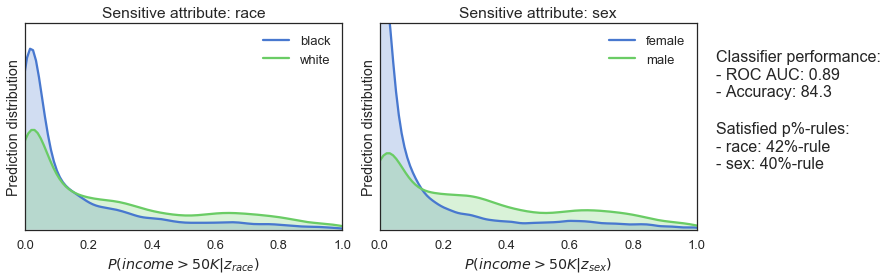

In [12]:
y_pre_clf = pd.Series(pre_clf_test.data.numpy().ravel(),
                      index=y_test.index)
_ = plot_dists(y_test, Z_test, y_pre_clf)

## Adverserial pre-train

In [13]:
class Adverserial(nn.Module):
    
    def __init__(self, n_sensitive, n_hidden=32):
        super(Adverserial, self).__init__()
        self.out = nn.Sequential(
            nn.Linear(1, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_sensitive),
        )
        
    def forward(self, x):
        return F.sigmoid(self.out(x))

In [14]:
def pretrain_adverserial(adv, clf, data_loader, optimizer, criterion):
    for x, _, z in data_loader:
        p_y = clf(x).detach()
        adv.zero_grad()
        p_z = adv(p_y)
        loss = criterion(p_z, z)
        loss.backward()
        optimizer.step()
    return adv

In [15]:
adv = Adverserial(Z_train.shape[1])
adv_criterion = nn.BCELoss()
adv_optimizer = optim.Adam(adv.parameters())

In [16]:
N_ADV_EPOCHS = 1

for epoch in range(N_ADV_EPOCHS):
    pretrain_adverserial(adv, clf, train_loader, adv_optimizer, adv_criterion)

In [17]:
with torch.no_grad():
    pre_adv_test = adv(pre_clf_test)
    
y_pre_adv = pd.DataFrame(pre_adv_test.numpy(), columns=Z.columns)

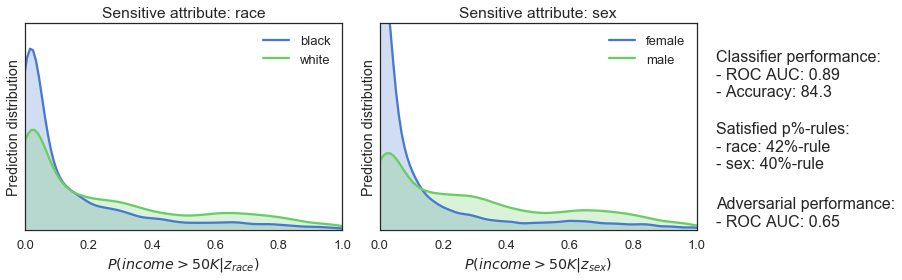

In [18]:
_ = plot_dists(y_test, Z_test, y_pre_clf, y_pre_adv)

## Combined train

In [19]:
clf_adv_criterion = nn.BCELoss(reduce=False)

In [20]:
lambdas = 0.1 * torch.Tensor([130, 30])

In [21]:
def train(clf, adv, data_loader, clf_criterion, adv_criterion,
          clf_adv_criterion, clf_optimizer, adv_optimizer):
    for x, y, z in data_loader:
        
        p_y = clf(x)

        # Train adversarial
        adv.zero_grad()
        p_adv = adv(p_y)
        loss_adv = adv_criterion(p_adv, z)
        loss_adv.backward(retain_graph=True)
        adv_optimizer.step()

        # Train classifier
        clf.zero_grad()
        clf_loss = clf_criterion(p_y, y) - (clf_adv_criterion(p_adv, z) * lambdas).sum()
        clf_loss.backward()
        clf_optimizer.step()
    
    return clf, adv

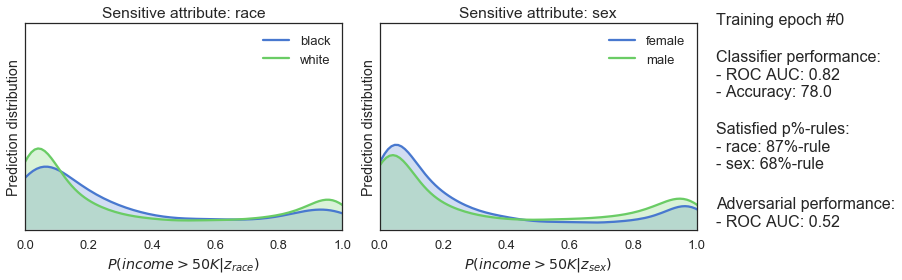

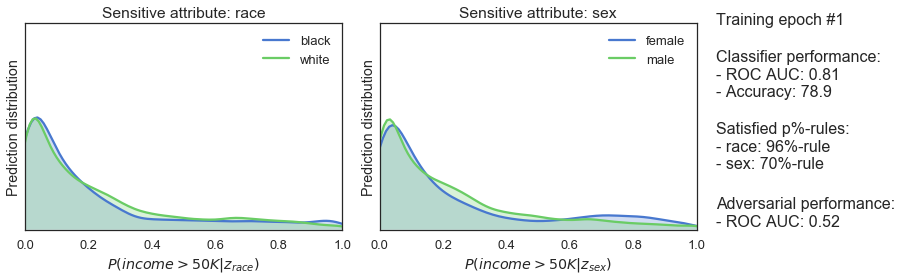

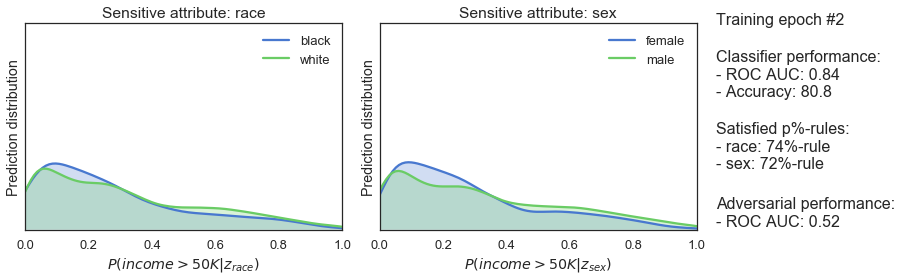

In [22]:
for epoch in range(3):
    
    clf, adv = train(clf, adv, train_loader, clf_criterion, adv_criterion,
                     clf_adv_criterion, clf_optimizer, adv_optimizer)
        
    with torch.no_grad():
        clf_pred = clf(test_data.X)
        adv_pred = adv(clf_pred)
    
    y_post_clf = pd.Series(clf_pred.numpy().ravel(), index=y_test.index)
    Z_post_adv = pd.DataFrame(adv_pred.numpy(), columns=Z_test.columns)

    plot_dists(y_test, Z_test, y_post_clf, Z_post_adv, epoch)